In [1]:
%pip -q install hmmlearn arch statsmodels pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from hmmlearn.hmm import GaussianHMM
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,5)
np.random.seed(42)

In [3]:
# ========= ПАРАМЕТРЫ =========
H            = 3        # ваш горизонт (как в таргете)
BASE_THR     = 0.53     # базовый порог уверенности proba_up
MARGIN_HIT   = 0.05     # на сколько p_hit_tp должно превосходить p_hit_sl
VOL_PCTL_ABS = 0.95     # пратежка: не торговать в топ-5% волатильности
TARGET_VOL   = 0.02     # дневной таргет под волатильность (пример)
F_MAX        = 0.02     # максимум доля капитала (ограничитель Келли)
TP_ATR_K     = 2      # базовый множитель ATR на TP (как в baseline)
SL_ATR_K     = 1      # базовый множитель ATR на SL (как в baseline)
# =============================

In [4]:
import os
from typing import Any, Dict, Optional
import pandas as pd
import pytz
from datetime import datetime, timedelta
from dotenv import load_dotenv
from tinkoff.invest import Client, CandleInterval
from dotenv import load_dotenv
import requests
import numpy as np

try:
    import xgboost as xgb
except ImportError:
    xgb = None  # type: ignore

try:
    import torch
    from torch import nn
    from torchvision import transforms
except ImportError:
    torch = None  # type: ignore

try:
    import timm
except ImportError:
    timm = None  # type: ignore

try:
    import mplfinance as mpf
    import matplotlib.pyplot as plt
except ImportError:
    mpf = None  # type: ignore

try:
    import pytz
except ImportError:
    pytz = None  # type: ignore


In [5]:
import os
import pandas as pd
import pytz
from datetime import datetime, timedelta
from dotenv import load_dotenv
from tinkoff.invest import Client, CandleInterval

# === Настройки ===
load_dotenv()
TOKEN = os.getenv("TINKOFF_TOKEN")
TICKER = "SBER"
DAYS = 1
TIMEFRAME = CandleInterval.CANDLE_INTERVAL_5_MIN
TZ = pytz.timezone("Europe/Moscow")

if not TOKEN:
    raise RuntimeError("❌ В .env не найден TINKOFF_TOKEN")

def fetch_tinkoff_candles(token: str, ticker: str, days: int = 1, interval=TIMEFRAME):
    from tinkoff.invest.services import InstrumentsService
    from tinkoff.invest.utils import now

    with Client(token) as client:
        # Получаем FIGI по тикеру
        instruments: InstrumentsService = client.instruments
        shares = instruments.shares().instruments
        figi = None
        for share in shares:
            if share.ticker.upper() == ticker.upper():
                figi = share.figi
                break
        if not figi:
            raise RuntimeError(f"FIGI для {ticker} не найден")

        # Получаем свечи
        end = now()
        start = end - timedelta(days=days)
        candles = client.get_all_candles(
            figi=figi,
            from_=start,
            to=end,
            interval=interval,
        )

        data = []
        for candle in candles:
            data.append({
                "time": candle.time.astimezone(TZ),
                "open": candle.open.units + candle.open.nano / 1e9,
                "high": candle.high.units + candle.high.nano / 1e9,
                "low": candle.low.units + candle.low.nano / 1e9,
                "close": candle.close.units + candle.close.nano / 1e9,
                "volume": candle.volume,
            })

        df = pd.DataFrame(data)
        return df

# === Проверка ===
print("🔑 Проверка токена и загрузка данных из Tinkoff API…")
try:
    # print(TOKEN)
    df = fetch_tinkoff_candles(TOKEN, TICKER, days=DAYS)
    print(f"✅ Успешно: {len(df)} свечей загружено")
    print(df.tail(5))
except Exception as e:
    print("❌ Ошибка:", e)


🔑 Проверка токена и загрузка данных из Tinkoff API…
✅ Успешно: 259 свечей загружено
                         time    open    high     low   close  volume
254 2025-11-04 13:10:00+03:00  298.00  298.04  298.00  298.04     164
255 2025-11-04 13:15:00+03:00  298.04  298.04  297.74  298.03     263
256 2025-11-04 13:20:00+03:00  297.75  298.04  297.72  298.03    1127
257 2025-11-04 13:25:00+03:00  298.03  298.03  297.72  298.03     327
258 2025-11-04 13:30:00+03:00  297.73  298.04  297.55  298.04    5359


In [6]:
def compute_ml_features(df: pd.DataFrame) -> pd.DataFrame:
    """Compute ML model features on a DataFrame of candles.

    The training script uses the following features:
    - ret_1: previous log return
    - sma_3, sma_5, sma_10: simple moving averages of 'close'
    - std_3, std_5, std_10: rolling standard deviations of log returns
    - atr_14: Average True Range over 14 periods (simplified)

    Parameters
    ----------
    df : pd.DataFrame
        Candle data sorted by time with columns ["time", "open", "high", "low", "close", "volume"].

    Returns
    -------
    pd.DataFrame
        DataFrame containing the computed feature columns.
    """
    df = df.copy().reset_index(drop=True)
    df["close"] = df["close"].astype(float)
    df["logret"] = np.log(df["close"]).diff()
    df["ret_1"] = df["logret"].shift(1)
    for w in [3, 5, 10]:
        df[f"sma_{w}"] = df["close"].rolling(window=w).mean()
        df[f"std_{w}"] = df["logret"].rolling(window=w).std()
    # True range components
    df["high"] = df["high"].astype(float)
    df["low"] = df["low"].astype(float)
    tr1 = df["high"] - df["low"]
    tr2 = (df["high"] - df["close"].shift(1)).abs()
    tr3 = (df["low"] - df["close"].shift(1)).abs()
    df["tr"] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df["atr_14"] = df["tr"].rolling(14).mean()
    feats = ["ret_1", "sma_3", "sma_5", "sma_10", "std_3", "std_5", "std_10", "atr_14"]
    return df[feats]


In [7]:
def predict_ml(
    model: xgb.Booster,
    feats_df: pd.DataFrame,
    return_proba: bool = True,
) -> Dict[str, Any]:
    """Run ML model inference on feature DataFrame.

    Parameters
    ----------
    model : xgb.Booster
        Loaded XGBoost model.
    feats_df : pd.DataFrame
        DataFrame of features with rows corresponding to time steps.
    return_proba : bool
        Whether to return class probabilities along with predicted labels.

    Returns
    -------
    dict
        Contains keys ``"labels"`` (list of str), ``"indices"`` (list of int),
        and optionally ``"proba"`` (np.ndarray of shape (n_samples, 3)).
    """
    dmatrix = xgb.DMatrix(feats_df)
    probs = model.predict(dmatrix)  # shape (n_samples, num_classes)
    preds = np.argmax(probs, axis=1)
    idx_to_label = {0: "down", 1: "flat", 2: "up"}
    labels = [idx_to_label.get(int(i), str(i)) for i in preds]
    result = {"indices": preds.tolist(), "labels": labels}
    if return_proba:
        result["proba"] = probs
    return result


In [8]:
import xgboost as xgb

def load_xgb_model(model_path: str) -> xgb.Booster:
    """Load a saved XGBoost model from file."""
    try:
        if xgb is None:
            raise ImportError(
                "xgboost is not installed. Install it via `pip install xgboost` to "
                "use the ML inference pipeline."
            )
        booster = xgb.Booster()
        booster.load_model(model_path)
    except Exception as e:
        import joblib
        booster = joblib.load("xgb_sber.model")
    return booster

In [9]:
def add_cv_features(df: pd.DataFrame) -> pd.DataFrame:
    """Compute technical indicators needed for candlestick chart rendering.

    Adds exponential moving averages (ema_10, ema_20) and Bollinger bands
    (boll_up, boll_low).  If these columns already exist they will be
    overwritten.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with at least a "close" column.

    Returns
    -------
    pd.DataFrame
        DataFrame with new columns ["ema_10", "ema_20", "boll_up", "boll_low"].
    """
    df = df.copy()
    df["ema_10"] = df["close"].ewm(span=10).mean()
    df["ema_20"] = df["close"].ewm(span=20).mean()
    mid = df["close"].rolling(20).mean()
    std = df["close"].rolling(20).std()
    df["boll_up"] = mid + 2 * std
    df["boll_low"] = mid - 2 * std
    return df


In [10]:
def render_candle_image(
    sub_df: pd.DataFrame,
    img_size: tuple = (8, 4),
    dpi: int = 100,
    use_jpg: bool = True,
    style: Optional[Any] = None,
) -> np.ndarray:
    """Render a single candlestick window into a NumPy RGB image.

    Parameters
    ----------
    sub_df : pd.DataFrame
        Subset of candle data covering the lookback window.  Must have index
        as datetime and columns open/high/low/close/volume along with
        optional ema_10, ema_20, boll_up, boll_low for overlay.
    img_size : tuple
        Figure size in inches (width, height).
    dpi : int
        Dots per inch for the figure.
    use_jpg : bool
        If True the image background is black; otherwise PNG with alpha.
    style : Optional
        mplfinance style to use.  If None, a night/clouds style is created
        similar to training.

    Returns
    -------
    np.ndarray
        Image as a HxWx3 uint8 array.
    """
    if mpf is None or plt is None:
        raise ImportError(
            "mplfinance and matplotlib must be installed to render candle images; "
            "install them via `pip install mplfinance matplotlib`"
        )
    # Default style matching the training notebook
    if style is None:
        mc = mpf.make_marketcolors(up="lime", down="red", edge="white", wick="white", volume="gray")
        style = mpf.make_mpf_style(
            base_mpf_style="nightclouds",
            facecolor="black",
            edgecolor="white",
            marketcolors=mc,
            rc={"axes.labelcolor": "white", "axes.edgecolor": "white"},
        )
    # Create figure and axes via mpf.plot and retrieve figure
    fig, axes = mpf.plot(
        sub_df,
        type="candle",
        style=style,
        volume=True,
        figsize=img_size,
        tight_layout=True,
        show_nontrading=True,
        returnfig=True,
    )
    # Remove axis details
    for ax in axes:
        ax.set_axis_off()
        ax.grid(False)
    # Overlay EMA and Bollinger if present
    if "ema_10" in sub_df.columns:
        axes[0].plot(sub_df.index, sub_df["ema_10"], color="deepskyblue", linewidth=1)
    if "ema_20" in sub_df.columns:
        axes[0].plot(sub_df.index, sub_df["ema_20"], color="orange", linewidth=1)
    if {"boll_up", "boll_low"}.issubset(sub_df.columns):
        axes[0].plot(sub_df.index, sub_df["boll_up"], color="gray", linestyle="--", linewidth=0.8)
        axes[0].plot(sub_df.index, sub_df["boll_low"], color="gray", linestyle="--", linewidth=0.8)
    # Draw to numpy array
    fig.canvas.draw()
    # img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    # img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    # plt.close(fig)
    buf = fig.canvas.buffer_rgba()
    w, h = fig.canvas.get_width_height()
    img = np.frombuffer(buf, dtype=np.uint8).reshape((h, w, 4))[..., :3]  # drop alpha
    plt.close(fig)
    return img


In [11]:
def prepare_cv_tensor(img: np.ndarray) -> torch.Tensor:
    """Convert an RGB image array into a Torch tensor with normalization.

    The normalization parameters match those used during training.

    Parameters
    ----------
    img : np.ndarray
        Image array with shape (H, W, 3) and dtype uint8.

    Returns
    -------
    torch.Tensor
        Tensor of shape (3, 224, 224) normalized for ConvNeXt.
    """
    if torch is None:
        raise ImportError(
            "torch must be installed to prepare image tensors; "
            "install it via `pip install torch torchvision`"
        )
    # Define the same transforms as in training
    transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )
    return transform(img).unsqueeze(0)  # add batch dimension


In [12]:
import json

def load_cv_model(meta_path: str, model_path: str, device: Optional[str] = None) -> nn.Module:
    """Reconstruct and load the CV model from saved state.

    Parameters
    ----------
    meta_path : str
        Path to meta.json file containing label_to_idx and model_name.
    model_path : str
        Path to the saved PyTorch checkpoint (state_dict).
    device : Optional[str]
        Device string (e.g. "cuda" or "cpu"); if None, will auto-detect.

    Returns
    -------
    torch.nn.Module
        Loaded model in evaluation mode.
    """
    if timm is None or torch is None:
        raise ImportError(
            "Both timm and torch must be installed to load the CV model; "
            "install via `pip install timm torch torchvision`"
        )
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    with open(meta_path, "r") as f:
        meta = json.load(f)
    label_to_idx: Dict[str, int] = meta["label_to_idx"]
    model_name: str = meta.get("model_name", "convnext_tiny")
    num_classes = len(label_to_idx)
    # Construct backbone
    backbone = timm.create_model(model_name, pretrained=False, num_classes=0, global_pool="avg")
    feat_dim = backbone.num_features  # type: ignore[attr-defined]
    # Define head exactly as in training
    head = nn.Sequential(
        nn.Linear(feat_dim, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes),
    )
    model = nn.Sequential(backbone, head)
    # Load weights
    checkpoint = torch.load(model_path, map_location=device)
    if "model_state" in checkpoint:
        state_dict = checkpoint["model_state"]
    else:
        state_dict = checkpoint
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model


In [13]:
def predict_cv(
    model: nn.Module,
    img_tensor: torch.Tensor,
    meta_path: str,
    device: Optional[str] = None,
    return_proba: bool = True,
) -> Dict[str, Any]:
    """Run the CV model on a single image tensor.

    Parameters
    ----------
    model : nn.Module
        Loaded CV model.
    img_tensor : torch.Tensor
        4D tensor (batch_size=1) representing the image.
    meta_path : str
        Path to meta.json to map indices back to labels.
    device : Optional[str]
        Device string ("cuda" or "cpu"); if None, automatically detected.
    return_proba : bool
        Whether to include probabilities in the result.

    Returns
    -------
    dict
        Contains keys ``"indices"`` (list of predicted indices), ``"labels"``
        (list of string labels), and optionally ``"proba"`` (np.ndarray).
    """
    if torch is None:
        raise ImportError("torch must be installed to perform CV inference")
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    img_tensor = img_tensor.to(device)
    with torch.no_grad():
        logits = model(img_tensor)
        probs = torch.softmax(logits, dim=1)
        pred_idx = probs.argmax(dim=1).cpu().numpy()
        probs_np = probs.cpu().numpy()
    # Load meta to map indices back to labels
    with open(meta_path, "r") as f:
        meta = json.load(f)
    idx_to_label = {v: k for k, v in meta["label_to_idx"].items()}
    labels = [idx_to_label.get(int(i), str(i)) for i in pred_idx]
    result = {"indices": pred_idx.tolist(), "labels": labels}
    if return_proba:
        result["proba"] = probs_np
    return result


In [14]:
def run_full_inference(
    ticker: str = "SBER",
    tf: str = "5m",
    days: int = 1,
    lookback: int = 60,
    ml_model_path: str = "xgb_sber.model",
    cv_model_path: str = "best_model.pth",
    meta_path: str = "meta.json",
    token: str = TOKEN,
    tz_name: str = "Europe/Amsterdam",
) -> Dict[str, Any]:
    """Run both the ML and CV models on the most recent candle data.

    Parameters
    ----------
    ticker : str
        Ticker symbol ("SBER" for Tinkoff, "SBER.ME" for Yahoo).  If no
        exchange suffix is provided for Yahoo, ".ME" is appended.
    tf : str
        Candle timeframe ("5m", "15m", etc.).
    start_date : Optional[str]
        If provided, overrides ``days`` and ``end_date``.  ISO date string.
    end_date : Optional[str]
        End date for fetching candles.  If None, uses current date.
    days : int
        Number of days of history to fetch when start_date is not given.
    lookback : int
        Number of candles to include in the CV model window.
    ml_model_path : str
        Path to saved XGBoost model (binary .model file).
    cv_model_path : str
        Path to saved PyTorch model (checkpoint from training).
    meta_path : str
        Path to meta.json containing the CV label mapping and backbone name.
    token : Optional[str]
        Tinkoff API token.  If None or empty, Yahoo Finance is used.
    tz_name : str
        Local timezone for candle timestamps and "now" determination.

    Returns
    -------
    dict
        Contains keys ``"ml_preds"`` and ``"cv_preds"`` with prediction
        dictionaries from each model.  Each dictionary contains indices,
        labels and (optionally) probabilities.
    """
    # Determine fetch range
    # Use days lookback from now
    df_candles = fetch_tinkoff_candles(token, ticker, days=DAYS)
    if df_candles.empty:
        raise RuntimeError("No candle data available for inference")
    # Sort by time just in case
    df_candles = df_candles.sort_values("time").reset_index(drop=True)

    # -----------------------------------------------------------------------
    # ML inference
    # -----------------------------------------------------------------------
    ml_model = load_xgb_model(ml_model_path)
    feats_df = compute_ml_features(df_candles).dropna()
    # Align features with candle timestamps (drop NaN rows resets index)
    ml_result = predict_ml(ml_model, feats_df, return_proba=True)

    # -----------------------------------------------------------------------
    # CV inference
    # -----------------------------------------------------------------------
    # Compute technical indicators needed for rendering
    df_feat = add_cv_features(df_candles)
    # Use the last ``lookback`` candles for the CV sample
    if len(df_feat) < lookback:
        raise ValueError(
            f"Not enough candles ({len(df_feat)}) for lookback={lookback}. "
            "Increase history length or decrease lookback."
        )
    sub = df_feat.iloc[-lookback:].copy()
    # Prepare index for mplfinance (datatime index required)
    sub["time"] = pd.to_datetime(sub["time"])
    sub = sub.set_index("time")
    # Render image to numpy array
    img = render_candle_image(sub, img_size=(8, 4), dpi=100, use_jpg=True)
    # Convert to tensor for model
    img_tensor = prepare_cv_tensor(img)
    # Load model
    cv_model = load_cv_model(meta_path, cv_model_path)
    # Run prediction
    cv_result = predict_cv(cv_model, img_tensor, meta_path, return_proba=True)

    return {"ml_preds": ml_result, "cv_preds": cv_result, "df_candles": df_candles}


In [15]:
def compute_atr_wilder(df, n=14):
    """True Range + Wilder's ATR, если нет atr_14 в CSV."""
    high = df['high'].astype(float)
    low  = df['low'].astype(float)
    close= df['close'].astype(float)
    prev_close = close.shift(1)

    tr1 = (high - low).abs()
    tr2 = (high - prev_close).abs()
    tr3 = (low  - prev_close).abs()
    tr  = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    atr = tr.ewm(alpha=1/n, adjust=False).mean()
    return atr

def fit_hmm_regimes(returns, n_states=2):
    X = returns.dropna().values.reshape(-1,1)
    if len(X) < 200:  # минимально, чтобы стабильно
        return None, None
    hmm = GaussianHMM(n_components=n_states, covariance_type='full',
                      n_iter=200, random_state=42)
    hmm.fit(X)
    hidden = pd.Series(hmm.predict(X), index=returns.dropna().index)
    return hmm, hidden.reindex(returns.index)

def garch_sigma(returns):
    # Еженаборная оценка σ_t через (E)GARCH: используем простой GARCH(1,1)
    r = (returns.dropna()*100).astype(float)  # проценты
    if len(r) < 300:
        return returns.abs().rolling(20).std().reindex(returns.index)
    am = arch_model(r, p=1, q=1, mean='Constant', vol='GARCH', dist='normal')
    res = am.fit(disp="off")
    cond_vol = res.conditional_volatility / 100.0  # обратно в доли
    return cond_vol.reindex(returns.index)

def arima_sign(returns):
    # Одношаговый ARIMA sanity-check (легкий)
    y = returns.dropna()
    if len(y) < 100:
        return pd.Series(index=returns.index, dtype=float)
    model = ARIMA(y, order=(1,0,1))
    res = model.fit()
    fc = res.forecast(1)
    sgn = np.sign(fc.iloc[0])
    return pd.Series(sgn, index=returns.index).ffill()

def mc_hit_probs(close_series, mu, sigma, H, n_paths=2000, dt=1):
    # Упрощенный GBM для hit-prob: вернём массив максимумов/минимумов за H шагов
    S0 = close_series.iloc[-1]
    z = np.random.normal(size=(n_paths, H))
    steps = (mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z
    paths = S0 * np.exp(np.cumsum(steps, axis=1))
    max_arr = paths.max(axis=1)
    min_arr = paths.min(axis=1)
    return max_arr, min_arr

def kelly_lite(prob_up, R=1.0, f_max=F_MAX):
    p = np.clip(prob_up, 1e-6, 1-1e-6)
    f = (p*R - (1-p))/R
    return float(np.clip(f, 0.0, f_max))

def overlays_postprocess(df):
    """
    Пост-обработка сигналов с жёстким консенсусом по лейблам.
    Сигнал строится ТОЛЬКО если:
      - есть оба лейбла: ml_label и cv_label
      - лейблы совпадают и это 'up' или 'down'
    Иначе по строке оставляем NaN-вероятности и пропускаем её при генерации сигналов.

    Поля входного df:
      - обязательно: time, close, high, low
      - желательно: ml_label, ml_proba, cv_label, cv_proba
      - опционально (учтутся только при наличии консенсуса): ml_proba_up/down, cv_proba_up/down
      - опционально: atr_14 (иначе считаем), предикторы для HMM/GARCH/ARIMA

    На выход добавляет: signal, tp_price, sl_price, size, regime, sigma_t, arima_sign, consensus_dir, proba_up, proba_down.
    """
    import numpy as np
    import pandas as pd

    # ---------------- helpers ----------------
    def _safe_float(x):
        try:
            v = float(x)
            return v if np.isfinite(v) else None
        except Exception:
            return None

    def _map_probs(label, p):
        """
        Превращает одну пару (label, p) -> (p_up, p_down).
        Остаток (1-p) делим поровну между двумя оставшимися классами.
        Возвращает None при любой проблеме.
        """
        try:
            if label is None:
                return None
            p = float(p)
            if not np.isfinite(p):
                return None
            p = float(np.clip(p, 0.0, 1.0))
            rem = max(0.0, 1.0 - p)
            lab = str(label).lower()
            if lab == 'up':
                return p, rem / 2.0
            elif lab == 'down':
                return rem / 2.0, p
            else:
                # 'flat' или прочее — равномерно между up/down
                return rem / 2.0, rem / 2.0
        except Exception:
            return None

    def _consensus_label(row):
        """
        Жёсткий консенсус: оба лейбла существуют, равны, и это 'up' или 'down'.
        Иначе None.
        """
        try:
            a = str(row.get('ml_label', '')).lower()
            b = str(row.get('cv_label', '')).lower()
            if a in {'up', 'down'} and a == b:
                return a
        except Exception:
            pass
        return None

    # ---------------- подготовка ----------------
    df = df.sort_values('time').reset_index(drop=True).copy()
    assert {'close', 'high', 'low'}.issubset(df.columns), "Нужны колонки close/high/low"

    # ATR при необходимости
    if 'atr_14' not in df.columns:
        df['atr_14'] = compute_atr_wilder(df, n=14)

    # Лог-доходности
    df['logret'] = np.log(df['close']).diff()

    # HMM режимы
    try:
        hmm, regimes = fit_hmm_regimes(df['logret'])
        df['regime'] = regimes
    except Exception:
        df['regime'] = np.nan

    # GARCH волатильность
    try:
        df['sigma_t'] = garch_sigma(df['logret'])
        vol_cut = df['sigma_t'].quantile(VOL_PCTL_ABS)
    except Exception:
        df['sigma_t'] = df['logret'].rolling(20).std()
        # запасной квантиль, если глобальная константа не задана
        vol_cut = df['sigma_t'].quantile(0.95)

    # Лёгкий ARIMA sign
    try:
        df['arima_sign'] = arima_sign(df['logret'])
    except Exception:
        df['arima_sign'] = np.nan

    # ---------------- консенсус + сбор вероятностей ----------------
    # 1) метка консенсуса
    df['consensus_dir'] = df.apply(_consensus_label, axis=1)

    # 2) строим proba_up/proba_down только там, где есть консенсус
    proba_up_vals, proba_down_vals = [], []
    for row in df.itertuples(index=False):
        # если нет консенсуса — строго NaN
        if getattr(row, 'consensus_dir', None) is None:
            proba_up_vals.append(np.nan)
            proba_down_vals.append(np.nan)
            continue

        ups, downs = [], []

        # из пар (label, proba)
        try:
            t = _map_probs(getattr(row, 'ml_label', None), getattr(row, 'ml_proba', None))
            if t is not None:
                ups.append(t[0]); downs.append(t[1])
        except Exception:
            pass

        try:
            t = _map_probs(getattr(row, 'cv_label', None), getattr(row, 'cv_proba', None))
            if t is not None:
                ups.append(t[0]); downs.append(t[1])
        except Exception:
            pass

        # прямые up/down поля учитываем ТОЛЬКО при наличии консенсуса
        try:
            u = _safe_float(getattr(row, 'ml_proba_up', None))
            d = _safe_float(getattr(row, 'ml_proba_down', None))
            if u is not None and d is not None:
                ups.append(u); downs.append(d)
        except Exception:
            pass

        try:
            u = _safe_float(getattr(row, 'cv_proba_up', None))
            d = _safe_float(getattr(row, 'cv_proba_down', None))
            if u is not None and d is not None:
                ups.append(u); downs.append(d)
        except Exception:
            pass

        if len(ups) > 0:
            proba_up_vals.append(float(np.mean(ups)))
            proba_down_vals.append(float(np.mean(downs)))
        else:
            # даже при консенсусе, если значений нет или они невалидны — NaN
            proba_up_vals.append(np.nan)
            proba_down_vals.append(np.nan)

    df['proba_up'] = pd.Series(proba_up_vals, index=df.index)
    df['proba_down'] = pd.Series(proba_down_vals, index=df.index)

    # ---------------- основной цикл сигналов ----------------
    out = []
    for i, row in df.iterrows():
        # Разогрев и NaN logret
        if i < 50 or pd.isna(row['logret']):
            out.append((0, float('nan'), float('nan'), 0.0))
            continue

        # Фильтр по волатильности
        if not pd.isna(row['sigma_t']) and row['sigma_t'] >= vol_cut:
            out.append((0, float('nan'), float('nan'), 0.0))
            continue

        # Жёстко требуем консенсус + валидные proba
        if pd.isna(row['consensus_dir']) or pd.isna(row['proba_up']) or pd.isna(row['proba_down']):
            out.append((0, float('nan'), float('nan'), 0.0))
            continue

        # Порог вероятности с поправкой на режим
        thr = BASE_THR
        try:
            if not pd.isna(row['regime']) and int(row['regime']) == 1:
                thr = BASE_THR + 0.05
        except Exception:
            pass

        # Направление фиксируем по консенсусу
        direction = 'long' if row['consensus_dir'] == 'up' else 'short'
        long_cond = (direction == 'long') and (row['proba_up'] >= thr)
        short_cond = (direction == 'short') and (row['proba_down'] >= thr)

        if not long_cond and not short_cond:
            out.append((0, float('nan'), float('nan'), 0.0))
            continue

        # ARIMA sanity-check: отфильтровать «почти на пороге» против знака
        if direction == 'long':
            if (not pd.isna(row['arima_sign']) and row['arima_sign'] < 0 and
                row['proba_up'] < (thr + 0.05)):
                out.append((0, float('nan'), float('nan'), 0.0))
                continue
        else:  # short
            if (not pd.isna(row['arima_sign']) and row['arima_sign'] > 0 and
                row['proba_down'] < (thr + 0.05)):
                out.append((0, float('nan'), float('nan'), 0.0))
                continue

        # ATR и sigma
        atr = row['atr_14']
        sigma = row['sigma_t'] if not pd.isna(row['sigma_t']) else df['logret'].rolling(20).std().iloc[i]
        step = max(TP_ATR_K * atr, 2.0 * sigma * row['close'])

        # Базовые TP/SL
        if direction == 'long':
            base_tp = row['close'] + step
            base_sl = row['close'] - step * (SL_ATR_K / TP_ATR_K)
        else:
            base_tp = row['close'] - step
            base_sl = row['close'] + step * (SL_ATR_K / TP_ATR_K)

        # Monte-Carlo фильтр hit-prob
        try:
            if not pd.isna(sigma) and sigma > 0:
                mu_loc = df['logret'].iloc[max(0, i-50):i].mean()
                max_arr, min_arr = mc_hit_probs(df['close'].iloc[:i+1],
                                                mu=mu_loc, sigma=sigma, H=H, n_paths=1500)
                if direction == 'long':
                    p_hit_tp = (max_arr >= base_tp).mean()
                    p_hit_sl = (min_arr <= base_sl).mean()
                else:
                    p_hit_tp = (min_arr <= base_tp).mean()
                    p_hit_sl = (max_arr >= base_sl).mean()
                if p_hit_tp < p_hit_sl + MARGIN_HIT:
                    out.append((0, float('nan'), float('nan'), 0.0))
                    continue
        except Exception:
            # если симуляция упала — не фильтруем
            pass

        # Сайзинг позиции: Келли + таргет-воль
        R = abs((base_tp - row['close']) / max(abs(row['close'] - base_sl), 1e-9))
        prob = row['proba_up'] if direction == 'long' else row['proba_down']
        f_kelly = kelly_lite(prob, R=R, f_max=F_MAX)
        size_vol = TARGET_VOL / max(sigma, 1e-6) if not pd.isna(sigma) else F_MAX
        size = float(np.clip(min(f_kelly, size_vol), 0.0, F_MAX))

        signal = 1 if direction == 'long' else -1
        out.append((signal, base_tp, base_sl, size))

    # ---------------- выходные столбцы ----------------
    df['signal']   = [o[0] for o in out]
    df['tp_price'] = [o[1] for o in out]
    df['sl_price'] = [o[2] for o in out]
    df['size']     = [o[3] for o in out]

    return df


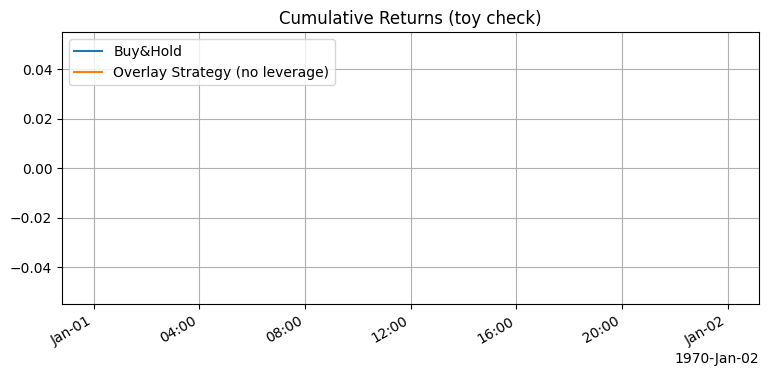

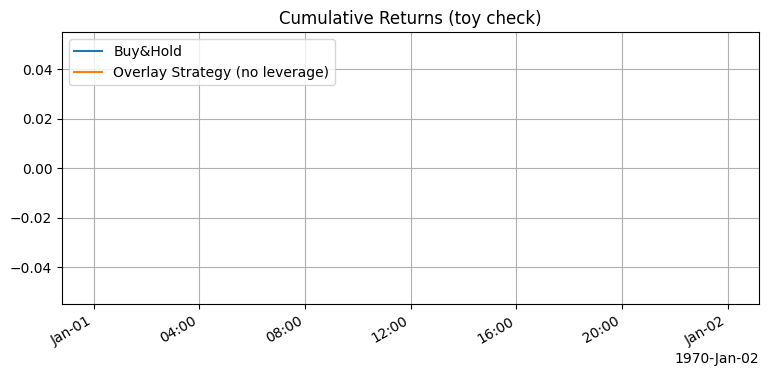

In [16]:
# один раз в начале (НЕ в цикле)
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import pandas as pd
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(9, 4))
(line_bh,) = ax.plot([], [], lw=1.5, label='Buy&Hold')
(line_st,) = ax.plot([], [], lw=1.5, label='Overlay Strategy (no leverage)')

ax.grid(True)
ax.legend(loc='upper left')
title_text = ax.set_title('Cumulative Returns (toy check)')

locator   = mdates.AutoDateLocator(minticks=4, maxticks=8)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
fig.autofmt_xdate()

display(fig)  # один-единственный display

def update_equity_plot(df_out):
    # ----- твоя логика, но без plt.plot/show -----
    df = df_out.copy()
    df = df.sort_values('time').reset_index(drop=True)

    df['ret_1'] = df['close'].pct_change()
    df['signal_shift'] = df['signal'].shift(1).fillna(0)
    df['str_ret'] = df['signal_shift'] * df['ret_1']

    bh = (1 + df['ret_1'].fillna(0)).cumprod()
    st = (1 + df['str_ret'].fillna(0)).cumprod()

    x = pd.to_datetime(df['time'])  # на всякий случай

    # обновляем существующие линии
    line_bh.set_data(x.values, bh.values)
    line_st.set_data(x.values, st.values)

    # пересчёт лимитов и перерисовка
    ax.relim()
    ax.autoscale_view()
    # обновим заголовок, если нужно (например, шаг/время)
    # title_text.set_text(f"Cumulative Returns (toy) — {x.iloc[-1]}")

    clear_output(wait=True)
    display(fig)

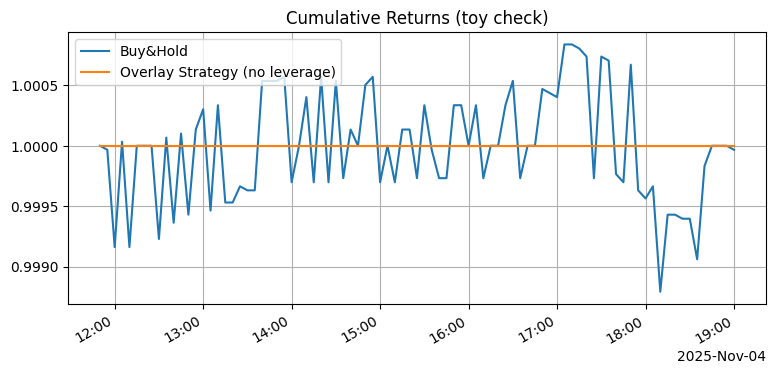

In [ ]:
import time
from datetime import datetime

load_dotenv()
TOKEN = os.getenv("TINKOFF_TOKEN")
TICKER = "SBER"
DAYS = 5
TIMEFRAME = CandleInterval.CANDLE_INTERVAL_5_MIN
TZ = pytz.timezone("Europe/Moscow")
LOOKBACK = 60
ml_model = "xgb_sber.model"
cv_model = "best_model.pth"
meta = "meta.json"
df_ml = pd.DataFrame()

while True:
    results = run_full_inference(
            ticker=TICKER,
            tf=TIMEFRAME,
            days=DAYS,
            lookback=LOOKBACK,
            ml_model_path=ml_model,
            cv_model_path=cv_model,
            meta_path=meta,
            token=TOKEN,
        )
    
    last_row = results["df_candles"].tail(1)
    df_ml = pd.concat([df_ml, last_row], ignore_index=True)

    ml_label = results["ml_preds"]['labels'][-1]
    ml_index = results["ml_preds"]['indices'][-1]
    ml_proba = results["ml_preds"]['proba'][-1][ml_index]

    cv_label  = results["cv_preds"]['labels'][-1]
    cv_index  = results["cv_preds"]['indices'][-1]
    cv_proba  = results["cv_preds"]['proba'][-1][cv_index]

    idx = df.index[-1]
    df.loc[idx, ['ml_label', 'ml_proba', 'cv_label', 'cv_proba']] = [ml_label, ml_proba, cv_label, cv_proba]

    # for i in df_ml.itertuples():
    #     try:
    #         ml_index = results["ml_preds"]['indices'][i.Index]

    #         df_ml["ml_label"][i.Index] = results["ml_preds"]['labels'][i.Index]
    #         df_ml["ml_index"][i.Index]  = results["ml_preds"]['indices'][i.Index]
    #         df_ml["ml_proba"][i.Index]  = results["ml_preds"]['proba'][i.Index][ml_index]
    #     except:
    #         pass

    #     try:
    #         cv_index = results["cv_preds"]['indices'][i.Index]

    #         df_ml["cv_label"][i.Index]  = results["cv_preds"]['labels'][i.Index]
    #         df_ml["cv_index"][i.Index]  = results["cv_preds"]['indices'][i.Index]
    #         df_ml["cv_proba"][i.Index]  = results["cv_preds"]['proba'][i.Index][ml_index]
    #     except:
    #         pass

    print(datetime.now())
    print("ML predictions:", results["ml_preds"]['labels'][-1], results["ml_preds"]['proba'][-1])
    print("CV predictions:", results["cv_preds"]['labels'][-1], results["cv_preds"]['proba'][-1])

    df_out = overlays_postprocess(df_ml)
    update_equity_plot(df_out)

    time.sleep(300)

In [ ]:
df_out

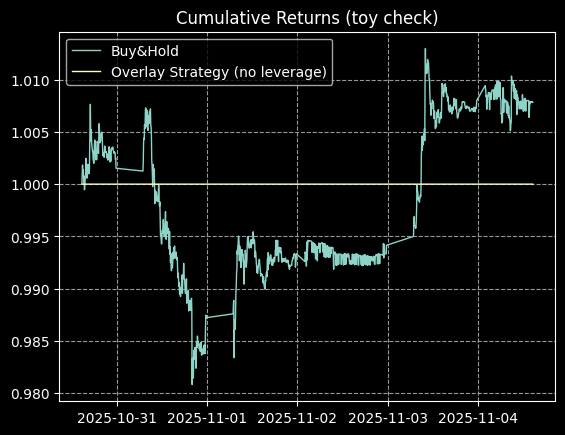

In [19]:
df = df_out.copy()
df = df.sort_values('time').reset_index(drop=True)

# Доходности (по close→close)
df['ret_1'] = df['close'].pct_change()

# Простая схема: если signal==1, считаем, что "держим позицию" на следующий шаг
df['signal_shift'] = df['signal'].shift(1).fillna(0)
df['str_ret'] = df['signal_shift'] * df['ret_1']    # без плеча, для прикидки

bh = (1+df['ret_1'].fillna(0)).cumprod()
st = (1+df['str_ret'].fillna(0)).cumprod()

plt.plot(df['time'], bh, label='Buy&Hold')
plt.plot(df['time'], st, label='Overlay Strategy (no leverage)')
plt.legend()
plt.title('Cumulative Returns (toy check)')
plt.grid(True)
plt.show()
